# Overview

This notebook (should) get you started with some time series analysis in python. Note, the stats models package is actively maintained...but if you want to do serious statistics, just get `R`.


Useful Link(s):
- http://pyspectrum.readthedocs.io/en/latest/index.html (difficult to use, has errors)
- https://www.statsmodels.org/stable/install.html (difficult to use, doesnt have all of the math we want)





# A note you should read...
"Rob Hyndman’s excellent forecast package in R is probably the most popular option, and Google and Twitter have both released packages with more specific time series functionality — CausalImpact and AnomalyDetection, respectively. As far as we can tell, there are few open source software packages for forecasting in Python."
    - Facebook
    
    
    
what does this mean? In short, there are limited "traditional" forecasting/timeseries functionalities avaliable for python. e.g. attempting to forecast a SVARIMA(2,3,1)(4,2,12) with drift is not eaisly possible. Strangely enough, there are many packages that enable spectral analysis (many relying on numpy's `numpy.fft.fftn()` or `nupy.fft.fft()` methods.  

## Useful packages

In [1]:
import pandas as pd
import statsmodels.api as sm
import numpy

from fbprophet import Prophet


import matplotlib as mp

/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
!pwd

/Users/jameshorine/repos/TimeSeriesTalk/code


In [3]:
beer = pd.read_csv("../data/quarterly-beer-production-in-aus.csv", header=0, index_col=0)

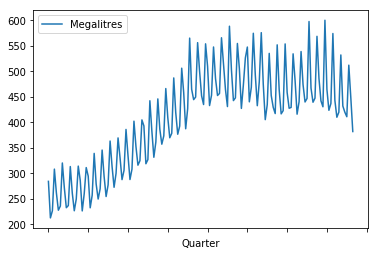

In [4]:
beer.plot()

In [5]:
beer.head()

,Megalitres
Quarter,
1956Q1,284.4
1956Q2,212.8
1956Q3,226.9
1956Q4,308.4
1957Q1,262.0


# Sample Autocorrelation

<bound method Figure.show of <matplotlib.figure.Figure object at 0x119ee2da0>>

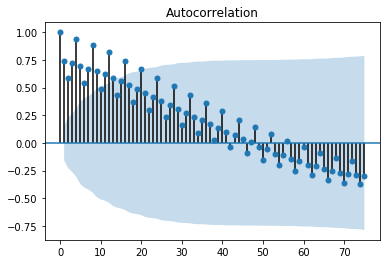

In [6]:
sm.graphics.tsa.plot_acf(beer, lags = 75).show

# Sample Partial-Autocorrelation

<bound method Figure.show of <matplotlib.figure.Figure object at 0x11e99e8d0>>

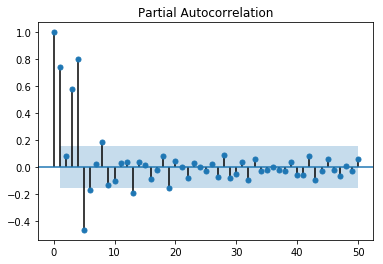

In [7]:
sm.graphics.tsa.plot_pacf(beer, lags = 50).show

# Sample Lagplots

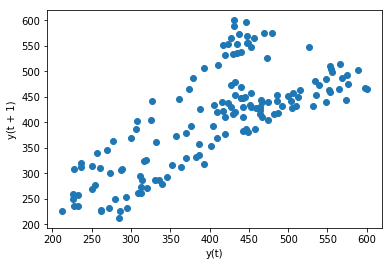

In [8]:
pd.plotting.lag_plot(beer, lag=1, )

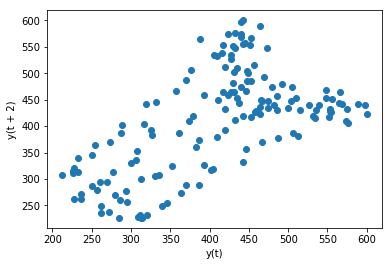

In [9]:
pd.plotting.lag_plot(beer, lag = 2)

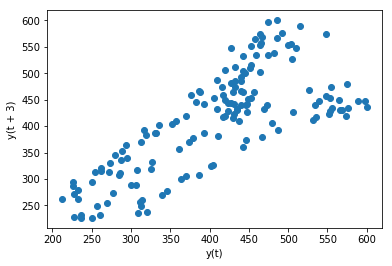

In [10]:
pd.plotting.lag_plot(beer, lag=3)

# Sample Power Spectrum 

The Sample Power Spectrum, or Sample Power Spectral Density, or Sample Periodogram, Or Sample Spectrum... same math, many names depending on the background of the practitioner. e.g. I know it as the Periodogram, because I learned from a...wiser...frumpy frequentist. 

The below code was my last (frusturated) attempt at delivering a reasonable estimate of the PSD. Many packages do it wrong, or in a way that is not abstract enough to handle other, potentially useful data strucutres (like series and data frames). 

Note 1: this assume the input series is REAL, i.e. NOT complex (of the form `a+bi`). In which case, the sample PSD calculation is merely the absolute-value (modulus in the complex field) squared of the real part of a real signal. In the complex case, you would want to look beyond a frequency of 0.5 as your signal almost certinaly contains information in that domain (Hermitian, NOT symmetric).

Note 2: period = 1/ frequency 
 - e.g. 1/0.25 = 4, the sample data below arrives as what kind of data? what is the sampling scheme? 4 quarters per...? 

In [11]:
sample_spectrum = pd.DataFrame()

In [12]:
sample_spectrum["log_power"] = numpy.log(pd.Series(abs(numpy.fft.fft(beer['Megalitres']))**2).iloc[0:((len(beer)//2) +1)])
sample_spectrum["fourier_frequency"] = pd.DataFrame([range(0,len(beer)//2)]).T.divide(len(beer))

In [13]:
sample_spectrum.shape

(78, 2)

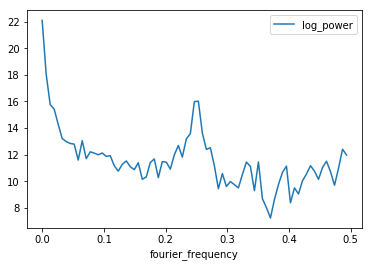

In [14]:
sample_spectrum.plot(x='fourier_frequency', y='log_power')

# Dealing with the pesky trend problem in Python

As the Facebook Prophet Team has noted, there really is no "good" open source alternative to `forecast` in Python. The `forecast` package utilizes widely accepted LOESS regression /regression splines to estimate the "trend" or "drift" of a time series process, then, subtracts that trend off from the orgional series, leaving a (hopefully) periodic series remaining for us to use relatively straightforward  techniques to estimate the remaining "appropriate" model parameters for the process. 

**sigh/gasp** that was kind of wordy. 

Now, because Python does NOT have a viable alternative to `forecast` we have a few options: 

1. Learn `R` (hint: its not that hard)
2. hand code all "appropriate" lagged variables and stuff them into a machine learning model of your choice 
3. use Facebook's `fbprophet` package to quickly pick through our relatively straightforward timeseries. 

## a brief overview of option (2)

In [15]:
def autoLagger(inputSeriesDataFrame, numberOfLagsDesired, padType = None, replaceValue = None):
    '''
    inputs:
    ------
    inputSeries : Pandas Series or Data Frame object 
    numberOfLagDesired : Integer input
    padType : None, sets the type of padding to do. 
    replaceValue : None, sets the value you wish to replace the induced NaN's with after lagging the data series. 
    
    Notes:
    -----
    1. I am not unit testing this function, so for the love of Alan Turing, please use a GD pandas object
    2. learn R 
    
    TODO:
    ----
    1. unit test! 
    2. use maps instead of for-loops for speed 
    3. profile function for speed
    4. profile function for memory useage 

    '''
    
    dataOut = pd.DataFrame(index = inputSeriesDataFrame.index)
    
    for k in range(1,numberOfLagsDesired):
        lagname = "Lag_"+str(k)
        dataOut[lagname] = inputSeriesDataFrame.shift(k)
     
    if padType == None:
        return("please specify NaN handling with `padType = drop` or `padType = replace`")
    
    elif padType == "drop":
        dataOut.dropna(inplace=True)
        return pd.concat([inputSeriesDataFrame, dataOut], axis = 1)
    
    elif padType == "replace":
        if replaceValue == None:
            return("please specify `replaceValue`")
        dataOut.fillna(value = replaceValue, inplace = True)

        return pd.concat([inputSeriesDataFrame, dataOut], axis = 1)
    
    
    
    

In [16]:
testdata = beer.head(10).copy()


In [17]:
autoLagger(testdata, 8, padType = "replace", replaceValue=0).corr()

,Megalitres,Lag_1,Lag_2,Lag_3,Lag_4,Lag_5,Lag_6,Lag_7
Megalitres,1.000000,-0.272553,-0.092376,0.349463,0.142219,-0.039763,0.045459,0.374169
Lag_1,-0.272553,1.000000,0.504571,0.450906,0.515573,0.375553,0.262229,0.280227
Lag_2,-0.092376,0.504571,1.000000,0.643184,0.563180,0.574464,0.430988,0.304212
Lag_3,0.349463,0.450906,0.643184,1.000000,0.701055,0.603578,0.566923,0.372148
Lag_4,0.142219,0.515573,0.563180,0.701055,1.000000,0.729255,0.626812,0.597135
Lag_5,-0.039763,0.375553,0.574464,0.603578,0.729255,1.000000,0.740946,0.649811
Lag_6,0.045459,0.262229,0.430988,0.566923,0.626812,0.740946,1.000000,0.721129
Lag_7,0.374169,0.280227,0.304212,0.372148,0.597135,0.649811,0.721129,1.000000


# From Here what would you do?... import sklearn as sk.... targets = , features =, model = SomeUsefulModel(), model.fit(), model.predict(), ect... 

# Or we can try `fbprophet`

In [18]:
beer.index

Index(['1956Q1', '1956Q2', '1956Q3', '1956Q4', '1957Q1', '1957Q2', '1957Q3',
       '1957Q4', '1958Q1', '1958Q2',
       ...
       '1992Q1', '1992Q2', '1992Q3', '1992Q4', '1993Q1', '1993Q2', '1993Q3',
       '1993Q4', '1994Q1', '1994Q2'],
      dtype='object', name='Quarter', length=154)

In [19]:
prophet_ready_data = pd.DataFrame()

In [20]:
prophet_ready_data["y"] = beer["Megalitres"]
prophet_ready_data["ds"] = beer.index
#prophet_ready_data["ds"] = numpy.arange(0,len(beer))

In [21]:
prophet_ready_data.head()

,y,ds
Quarter,,
1956Q1,284.4,1956Q1
1956Q2,212.8,1956Q2
1956Q3,226.9,1956Q3
1956Q4,308.4,1956Q4
1957Q1,262.0,1957Q1


In [22]:
# Python
m = Prophet()
m.fit(prophet_ready_data)


INFO:fbprophet.forecaster:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/anaconda3/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


In [23]:
future = m.make_future_dataframe(periods=20, freq = "Q")
future.tail()

,ds
169,1998-03-31
170,1998-06-30
171,1998-09-30
172,1998-12-31
173,1999-03-31


In [24]:
fcst = m.predict(future)
fcst.tail()

,ds,trend,trend_lower,trend_upper,yhat_lower,yhat_upper,additive_terms,additive_terms_lower,additive_terms_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yearly,yearly_lower,yearly_upper,yhat
169,1998-03-31,471.894782,466.567363,477.824740,383.176751,431.084845,-64.114883,-64.114883,-64.114883,0.0,0.0,0.0,-64.114883,-64.114883,-64.114883,407.779899
170,1998-06-30,471.323172,465.373569,477.977057,390.752350,436.630614,-58.707373,-58.707373,-58.707373,0.0,0.0,0.0,-58.707373,-58.707373,-58.707373,412.615798
171,1998-09-30,470.745280,464.179835,477.835720,496.353671,542.609606,47.352888,47.352888,47.352888,0.0,0.0,0.0,47.352888,47.352888,47.352888,518.098168
172,1998-12-31,470.167388,462.945304,477.890237,429.322289,478.362052,-16.731460,-16.731460,-16.731460,0.0,0.0,0.0,-16.731460,-16.731460,-16.731460,453.435928
173,1999-03-31,469.602059,461.881336,478.157461,383.214208,430.369736,-63.125856,-63.125856,-63.125856,0.0,0.0,0.0,-63.125856,-63.125856,-63.125856,406.476203


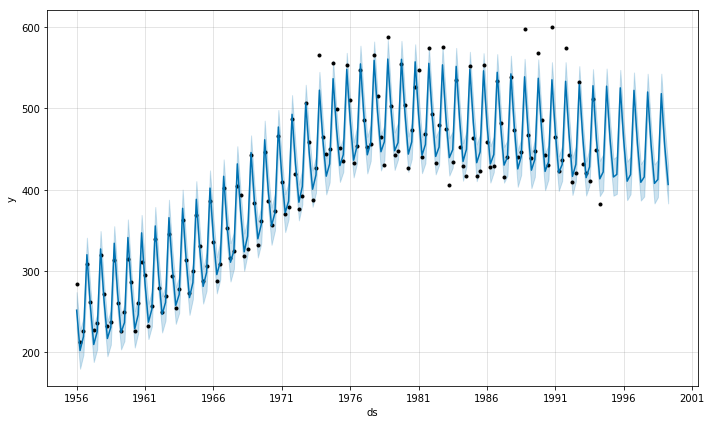

In [25]:
fig = m.plot(fcst)

# continued reading: 

https://anomaly.io/seasonal-trend-decomposition-in-r/

http://pkg.robjhyndman.com/forecast/

(gosh these are all in R?....) 

...Yes, they are... anything you can do in R, you can do with bespoke Python code. To be frank, a lot of time series problems will require specialized code in order to handle the numerous intricacies of the data. 


# a great easy to use reference
https://otexts.org/fpp2/


